[En français](../use-case-oafeat-en/)  

![ECCC logo](https://eccc-msc.github.io/open-data/img_eccc-logo.png)  

[TOC](https://eccc-msc.github.io/open-data/readme_en/) > [Usage overview](https://eccc-msc.github.io/open-data/usage/readme_en/) > OGC API - Features request in Python

# Use case: Tracking water level with GeoMet-OGC-API

## Introduction

Hydrometric data from the Meteorological Service of Canada (MSC) and Environment and Climate Change Canada (ECCC) can be easily accessed via [GeoMet-OGC-API](https://geo.weather.gc.ca/geomet/features/?f=html). The [OGC API - Features](https://eccc-msc.github.io/open-data/msc-geomet/web-services_en/#ogc-api-features) web services available in [GeoMet-OGC-API](https://geo.weather.gc.ca/geomet/features/?f=html) offer the capability to query vector geospatial data and retrieve it in a GeoJSON format. The GeoJSON file can than be used for display or further data processing. This use case will show you how you can:
* Query and retrieve vector geospatial data from [GeoMet-OGC-API](https://geo.weather.gc.ca/geomet/features/?f=html) with [Python](https://www.python.org/)
* Display the retrieved data on a web map
* Analyse the data and display the results in graphic and tabular format
* Export the data in a format of your choice

An [interactive version of this Jupyter Notebook is available](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case/main?filepath=docs%2Fuse-case-oafeat-en.ipynb)

[![badge](https://img.shields.io/badge/Interactive%20version-binder-F5A252.svg?logo=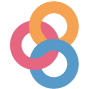)](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case/main?filepath=docs%2Fuse-case-oafeat-en.ipynb)

## Creation of a tool to track water level 

Cathy runs a boat tours and water sports company in Chilliwack, British-Columbia. She would like to track the water level of a few hydrometric stations near her city to guide the management of the company activities. She would like to have:
* An overview of the distribution of the daily water level of the past 3 months for all hydrometric stations located within 100 km of the city of Chilliwack (minimum, first quartile, median, third quartile and maximum) 
* A graphic view that presents the provisional daily mean water level of the past 3 months with a color code to indicate the water level status
* A tabular view that shows the provisional daily mean water level of the past 3 months with the same color code
* A web map that displays the hydrometric stations located within 100 km of the city of Chilliwack and the most recent provisional daily mean water level of these stations with the appropriate color code
* The provisional daily mean water level of the past 3 months in a WaterML2.0 format for exportation

To achieve this, the first step is to retrieve the hydrometric stations data from [GeoMet-OGC-API](https://geo.weather.gc.ca/geomet/features/?f=html) with Python.

In [1]:
# Module importation
from datetime import date

from dateutil.relativedelta import relativedelta
from ipyleaflet import (Map, basemaps, WidgetControl, Icon, Marker,
 FullScreenControl, AwesomeIcon, LegendControl, ScaleControl)
from ipywidgets import HTML, interactive, interact
from osgeo import ogr, osr
from owslib.ogcapi.features import Features
import pandas as pd

In [2]:
# Parameters

# Coordinates
lat = 49.162676
long = -121.958943

# Buffer size in kilometer
buffer = 100

# Number of months used to analyse historical data
num_months = 3

# Prefered projection
# NAD83 / Statistics Canada Lambert
projection = 3347 

In [3]:
# Generating parameters for the OGC API - Features request

# Bounding box a little bigger than buffer size (1 km ≈ 0.01°)
bbox = [str(long-(buffer/2)*0.01),
        str(lat-(buffer/2)*0.01),
        str(long+(buffer/2)*0.01),
        str(lat+(buffer/2)*0.01)
       ]

# Time
end_date = date.today()
end_date = date(2012, 7, 20) # Available data to test the code, will not be in final use case
start_date = end_date - relativedelta(months=num_months)
delta_time = (end_date - start_date).days
time = f'{start_date.strftime("%Y-%m-%d")}/{end_date}'

In [4]:
# Retrieval of hydrometric stations data
oafeat = Features('https://geo.weather.gc.ca/geomet/features')
station_data = oafeat.collection_items('hydrometric-stations', 
                                       bbox=bbox,
                                       STATUS_EN='Active')

In [5]:
# Generating a list of stations inside the buffer zone

# Set the driver
driver = ogr.GetDriverByName('GeoJSON')

# Create a datasource and get the layer
station_data = str(station_data).replace("'", '"').replace("None", "null")
data_source = driver.Open(station_data, 0) # 0 means read-only. 1 means writeable.
layer = data_source.GetLayer()

# Identify input spatial reference system
srs_input = layer.GetSpatialRef()
sr = osr.SpatialReference(str(srs_input))
epsg = sr.GetAuthorityCode(None)
srs_input.ImportFromEPSG(int(epsg))

# Spatial reference system used to project data
srs_projected = osr.SpatialReference()
srs_projected.ImportFromEPSG(projection)

# Transformation from input srs to NAD83 / Statistics Canada Lambert
transform = osr.CoordinateTransformation(srs_input, srs_projected)

# Create a buffer to select stations
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(long, lat)
point.Transform(transform)
point_buffer = point.Buffer(buffer*1000) # The value must be in meters

# Select the stations in the buffer zone
stations = []
for feature in layer:
    geom = feature.GetGeometryRef().Clone()
    geom.Transform(transform)
    if geom.Intersects(point_buffer):
        stations.append(feature.GetField('STATION_NUMBER'))

In [6]:
# Retrieval of hydrometric data for each station

# Function to associate a status to each water level
def level_status(level_value, df):
    if level_value < df.quantile(0.25)[0]:
        status = 'Low'
    elif level_value > df.quantile(0.75)[0]:
        status = 'High'
    else:
        status = 'Medium'
    return status

# Dictionary that will contain a data frame for each station 
water_level = {}

# Dictionary that will contain a data frame for the latest 
# data of all stations
latest_data = {'ID':[],
               'Name':[],
               'Level':[],
               'Timestamp':[],
               'Status':[],
               'Latitude':[],
               'Longitude':[]}

# List of stations with missing data
to_remove = []

# Retrieval of the data and creation of the data frames
for station in stations:
    
    # Retrieval of hydrometric stations water level data
    hydro_data = oafeat.collection_items(
        'hydrometric-daily-mean',
        bbox=bbox,
        time=time,
        STATION_NUMBER=station
    )
    
    dates = []
    level_values = []
    for feature in hydro_data['features']:
        dates.append(feature['properties']['DATE'])
        level_values.append(feature['properties']['LEVEL'])
        
    if (len(level_values) == delta_time + 1 and 
            not all(val is None for val in level_values) and
            level_values[-1] is not None):
        water_level_data = {'Daily mean': level_values}
        water_level_df = pd.DataFrame(
            water_level_data, index=dates, columns=['Daily mean']
        )
        water_level_df['Status'] = water_level_df['Daily mean'].apply(
            level_status, df=water_level_df
        )
        water_level[station] = water_level_df
        
        last_value = hydro_data['features'][-1]
        latest_data['ID'].append(station)
        latest_data['Name'].append(last_value['properties']['STATION_NAME'])
        latest_data['Level'].append(
            round(last_value['properties']['LEVEL'], 2)
        )
        latest_data['Timestamp'].append(last_value['properties']['DATE'])
        latest_data['Status'].append(water_level_df['Status'][-1])
        latest_data['Latitude'].append(
            last_value['geometry']['coordinates'][1]
        )
        latest_data['Longitude'].append(
            last_value['geometry']['coordinates'][0]
        )
        
    else:
        to_remove.append(station)
        
for station in to_remove:
    stations.remove(station)
    
latest_data_df = pd.DataFrame.from_dict(latest_data)

In [7]:
# Creation of an interactive plot with pandas and plotly
pd.options.plotting.backend = 'plotly'
    

def choose_station(station):
    
    # Latest data
    curr_value = water_level[station]['Daily mean'].iloc[-1]
    curr_status = water_level[station]['Status'].iloc[-1]
    curr_date = water_level[station].index.max()
    
    # Historical data
    historical_min = float(water_level[station]['Daily mean'].min())
    historical_max = float(water_level[station]['Daily mean'].max())
    
    # Number of level values
    num_values = len(water_level[station].index)
    
    # Current level line color that to indicate the water level status
    if curr_status == 'Low':
        curr_color = 'limegreen'
    elif curr_status == 'High':
        curr_color = 'red'
    else:
        curr_color = 'cornflowerblue'
    
    # Creation of the plot
    fig = water_level[station]['Daily mean'].plot(
        title='Water level at station {}'.format(station), 
        template='plotly_white',
        labels=dict(index='Date',
                    value='Water level (m)'),
        color_discrete_sequence=['gray']
    ).add_scatter(  # Historical maximum line
        y=[historical_max] * num_values,
        x=water_level[station].index,
        name='Historical maximum',
        line=dict(color='red', 
                  dash='dash'),
        text=f'Historical maximum: {round(historical_max, 3)}',
        hoverinfo='x+text',
        legendgroup='General legend'
    ).add_scatter(  # Historical minimum line
        y=[historical_min] * num_values,
        x=water_level[station].index,
        name='Historical minimum',
        line=dict(color='limegreen', 
                  dash='dash'),
        text=f'Historical minimum: {round(historical_min, 3)}',
        hoverinfo='x+text',
        legendgroup='General legend'
    ).add_scatter(  # Current level legend header
        y=[curr_value],
        x=[curr_date],
        name='Current level',
        legendgroup='Current value legend',
        opacity = 0
    ).add_scatter(  # High level legend key
        y=[curr_value],
        x=[curr_date],
        name='High',
        line=dict(color='red'),
        legendgroup='Current value legend'
    ).add_scatter(  # Medium level legend key
        y=[curr_value],
        x=[curr_date],
        name='Medium',
        line=dict(color='cornflowerblue'),
        legendgroup='Current value legend'
    ).add_scatter(  # Low level legend legend key
        y=[curr_value],
        x=[curr_date],
        name='Low',
        line=dict(color='limegreen'),
        legendgroup='Current value legend'
    ).add_scatter(  # Current level line
        y=[curr_value] * num_values,
        x=water_level[station].index,
        name='Current level',
        line=dict(color=curr_color),
        showlegend=False
    )
    # Updating some plot parameters
    fig.update_traces(legendgroup='General legend',
                      selector=dict(name='Daily mean'))
    fig.update_traces(hovertemplate=None,
                      mode='lines')
    fig.update_layout(hovermode='x unified', 
                      legend_title=None,
                      legend_tracegroupgap=25,
                      yaxis=dict(range=[historical_min - 0.1,
                                        historical_max + 0.1]))
    # Traces added to create the custom legend shouldn't be included
    # in the information shown when hovering over the plot
    fig.update_traces(hoverinfo='skip',
                      selector=dict(egendgroup='Current value legend'))
    return fig


# Creation of the dropdown menu widget
graph = interact(choose_station, station=stations)

interactive(children=(Dropdown(description='station', options=('08MH147', '08MH167', '08MF035', '08MF072', '08…

In [8]:
# Creation of the table

# Option to show all rows
pd.set_option('max_rows', None)

# Function to change cell color according to
# current water level status
def cell_color(row, status):
    cell = row.index.get_loc('Daily mean')
    color = ['' for _ in row.index]
    if status.loc[row.name] == 'Low':
        color[cell] = 'background-color: limegreen'
    elif status.loc[row.name] == 'High':
        color[cell] = 'background-color: red'
    else:
        color[cell] = 'background-color: cornflowerblue'
    return color

def choose_station_table(station):
    df = water_level[station][['Daily mean']]
    return df.style.apply(cell_color,
                          axis=1,
                          status=water_level[station]['Status'])

table = interact(choose_station_table, station=stations)

interactive(children=(Dropdown(description='station', options=('08MH147', '08MH167', '08MF035', '08MF072', '08…

In [9]:
# Creation of the interactive map

# Parameters
center = [lat, long]
zoom = 9

# Map
m = Map(basemap=basemaps.CartoDB.Positron, center=center, zoom=zoom)

# Adding hover information
html = HTML('Hover Over Hydrometric Stations')
html.layout.margin = '0px 10px 10px 10px'
control = WidgetControl(widget=html, position='topright', max_width=250)
m.add_control(control)


def get_callback(marker):
    def callback(*args, **kwargs):
        html.value = '''
            <b>{}</b><br>
            Station ID: {}<br>
            Date: {}<br>
            Water level: {} m
        '''.format(marker.Name,
                   marker.ID,
                   marker.Timestamp,
                   marker.Level)
        
    return callback


# Adding legend
legend = LegendControl(
    {'High':'#c64b36', 
     'Medium':'#09639b', 
     'Low':'#6da824'}, 
    position='bottomright',
    name='Water level')
m.add_control(legend)

# Adding scale and full screen control
m.add_control(ScaleControl(position='bottomleft'))
m.add_control(FullScreenControl())

# Marker colors according to current water level status
marker_color = {'Low': 'green',
                'Medium': 'darkblue',
                'High': 'red'}

# Adding a marker to the map for each hydrometic station
for index, row in latest_data_df.iterrows():
    icon = AwesomeIcon(
        name='tint',
        marker_color=marker_color[row.Status]
    )
    station_marker = Marker(icon=icon, location=[row.Latitude, row.Longitude])
    station_marker.on_mouseover(get_callback(row))
    m.add_layer(station_marker)
    
# Display the map
display(m)

Map(center=[49.162676, -121.958943], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…